# Binary Clustering example
We try to separate two sets of clustered data by maping the optimization problem to an Ising hamiltonian, the ground state of which can be found using Quantum Annealing Techniques.
Based on the paper: https://arxiv.org/pdf/1706.05528.pdf

Let $\displaystyle x_1,...,x_n$ be the data points that we want to separate. Then $\displaystyle X=[x_1,...,x_n]$ is an $\displaystyle m\times n$ matrix and the optimization problem that we have to solve to separate the data points in two clusters is:
$\displaystyle \text{argmin}_{s\in\{-1,1\}^n}-\sum_{i,j=1}^nQ_{ij}s_is_j$ 

where $\displaystyle Q_{ij}=x_i^Tx_j$. We can simply consider this problem as finding the ground state of the Hamiltonian:

$\displaystyle H_P=-\sum_{i,j=1}^nQ_{ij}\sigma^i_z\sigma_z^j$

This can be done using Quantum Annealing. We consider the hamiltonian

$\displaystyle H_B=-\sum_{i=1}^n\sigma_x^i$

whose ground state $|\psi(0)\rangle$ is easier to calculate. Then we construct the Hamiltonian:

$H(t)=(1-\frac{t}{\tau})H_B+\frac{t}{\tau}H_P$

and consider the evolution for a time $t\in[0,\tau]$ of the state $|\psi(0)\rangle$ under this hamiltonian.

According to the adiabatic theorem, the state:

$|\psi(t)\rangle=\sum_{i=0}^{2^n-1}a_i(t)|\psi_i\rangle$

will tend to evolve towards the ground state of $H_P$ if the evolution is done sufficiently slow. Then, in principle the maximum of the $|a_i(\tau)|^2$ will indicate which is the basis vector $|\psi_i\rangle$ which is the solution to the optimization problem.

### Generating the Ising Hamiltonian

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

def generate_Hp(N, X):
    # N is the length of the chain
    # X is the array of data points
    Q = np.transpose(X)@X
    
    si = qeye(2)
    sz = sigmaz()

    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    Hp = 0

    for n in range(N):
        for m in range(N):
            Hp += - Q[n,m] * sz_list[n] * sz_list[m]
        
    return Hp

def generate_Hb(N):
    # N is the length of the chain
    
    si = qeye(2)
    sx = sigmax()

    sx_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

    # construct the hamiltonian
    Hb = 0

    for n in range(N):
        Hb += - sx_list[n]
        
    return Hb

# now we build the time-dependent terms of the Hamiltonian H(t):

def Hp_coeff(t, args):
    tau = args['tau'] # time scale of the adiabatic evolution
    return t/tau

def Hb_coeff(t,args):
    tau = args['tau'] # time scale of the adiabatic evolution
    return 1-t/tau

def adiabatic_evolution(H, N, args, psi0, tlist, plot = True):
    # evolve and calculate expectation values
    # H: Hamiltonian in the format H = [[Hb, Hb_coeff],[Hp, Hp_coeff]]
    # args: arguments of the time dependent function of the hamiltonian, args = {'tau': tau}
    # psi0: initial state to be evolved
    # tlist: list of times for which the evolution is calculated

    c_op_list = [] # we are not using any colapse operators
    si = qeye(2)
    sz = sigmaz()
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        op_list[n] = sz
        sz_list.append(tensor(op_list))
     
    options = Options(nsteps=100000, store_states = True)
    result = mesolve(H, psi0, tlist, c_op_list, sz_list, args = args, options = options) # calculate the expected value of the sigma_z
    #result_state = mesolve(H, psi0, tlist, c_op_list, args = args, options = options) # calculate evolved state at each time
    
    # plot sigma_z evolution
    if plot == True:
        plt.subplots(figsize=(10,6))
        plt.imshow(np.real(result.expect), interpolation = 'nearest', extent=[tlist[0], tlist[-1], N, 0], aspect = 'auto')
        plt.aspect_ratio = 1
        plt.colorbar()
        plt.xlabel(r'Time')
        plt.yticks(list(range(N)))
        plt.ylabel(r'N site')
        plt.title(r'$\langle\sigma_z\rangle$ evolution of a spin chain')
        
    return result.expect, result.states

def entanglement_entropy(state, partition):
    # Returns the Von Neumann entropy of the partial trace
    # state - state for which we want to calculate the entanglement entropy
    # partition - integer or array of integers from 0 to N-1 that indicate the subsystem
    # with respect to which we calculate the partial trace
    dm = state*state.dag()
    partial_dm = dm.ptrace(partition)
    return entropy_vn(partial_dm, base = 2)

def H_time(t, Hb, Hp, tau):
    # Time dependent hamiltonian as a function
    return (1-t/tau)* Hb + t/tau * Hp
     
def gap_evolution(H, tlist, plot = True):
    # Hamiltonian evaluated at different times
    energy_0 = [] # ground state energies
    energy_1 = [] # first excited state energies
    gap = [] # diference between ground and first excited energies
    
    for H_i in H:
        energies = H_i.eigenenergies(sparse=False, sort='low', eigvals=3, tol=0, maxiter=100000)
        energy_0.append(energies[0])
        energy_1.append(energies[2])
        gap.append(energies[2]-energies[0])

    if plot == True:
        plt.figure(figsize=(8,6))
        plt.plot(tlist, gap)
        plt.xlabel(r'Time')
        plt.ylabel(r'Gap')
    return energy_0, energy_1

def generate_data(n1, n2, plot = True):
    # n1 number of points of the first cluster
    # n2 number of points of the second cluster
    mean1 = [1, 1]
    mean2 = [-1,-1]
    cov = [[1, 0], [0, 1]] 
    # we sample the points from two 2d gaussian distributions
    x1, y1 = np.random.multivariate_normal(mean1, cov, n1).T
    x2, y2 = np.random.multivariate_normal(mean2, cov, n2).T
    points1 = np.array(list(zip(x1,y1)))
    points2 = np.array(list(zip(x2,y2)))
    data = np.concatenate((points1, points2), axis=0).T
    
    if plot == True:
        plt.figure(figsize=(8,6))
        plt.plot(x2, y2, 'x')
        plt.plot(x1, y1, 'o')
        
        plt.title('Generated data points')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis('equal')
    return data

def cluster(N, data, expectation):
    # N: number of data points = number of spins
    # data: data points
    # expectation: sigma_z expectation of each spin for different t
    data_t = data.T
    # list of index corresponding to each cluster
    cluster1 = []
    cluster2 = []
    for i in range(N):
        expectation_i = expectation[i]
        if expectation_i[-1] >= 0:
            cluster1.append(data_t[i])
        else:
            cluster2.append(data_t[i])
    C1 = np.array(list(zip(*cluster1)))
    x1 = C1[0]
    y1 = C1[1]
    C2 = np.array(list(zip(*cluster2)))
    x2 = C2[0]
    y2 = C2[1]
    
    plt.figure(figsize=(8,6))
    plt.plot(x2, y2, 'x')
    plt.plot(x1, y1, 'o')
    plt.title('Clustered data points')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    
    return cluster1, cluster2

def overlap_with_ground(H, states, tlist):
    #n = 1
    #eigenenergies = H.eigenenergies(sparse=False, sort='low', eigvals=2, tol=0, maxiter=100000)
    #if eigenenergies[0] == eigenenergies[1]:
     #   n = 2
    n = 3
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=n, tol=0, maxiter=100000)
    overlaps = []
    for i in range(n):
        overlap = []
        for state in states:
            overlap.append(abs(eigenstates[1][i].overlap(state))**2)
        overlaps.append(overlap)
    plt.figure(figsize=(8,6))
    plt.plot(tlist, overlaps[0], label = 'ground state 1')
    plt.plot(tlist, overlaps[1], label = 'ground state 2')
    plt.plot(tlist, overlaps[2], label = '1st excited')
    plt.xlabel('time')
    plt.ylabel('overlap square')
    plt.legend()
    return overlaps

### First trial


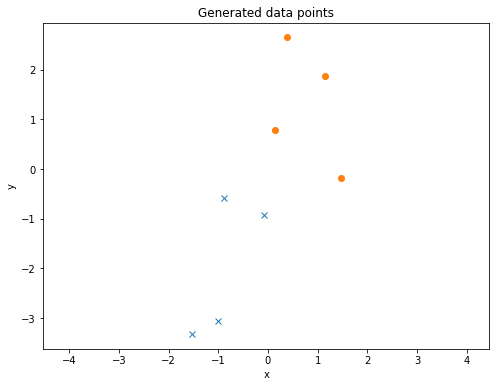

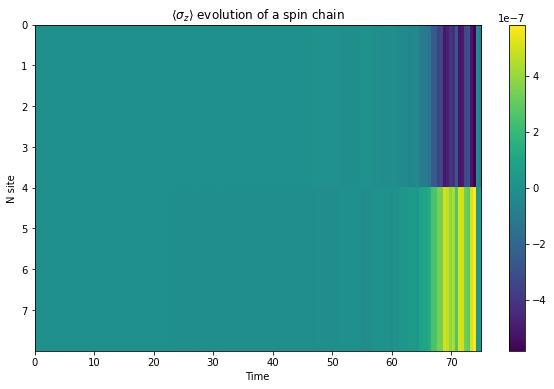

In [94]:
n1 = 4
n2 = 4

N = n1 + n2 # number of data points = length of the spin chin

X = generate_data(n1,n2)

Hb = generate_Hb(N)
Hp = generate_Hp(N,X)

tau = 75 # time scale of the adiabatic evolution
args = {'tau': tau}

ground = Hb.groundstate(sparse=False, tol=0, maxiter=100000)
psi0 = ground[1] # initial state is the ground state of Hb

tlist = np.linspace(0, tau, tau*2)

# time dependent hamiltonian
H = [[Hb, Hb_coeff], [Hp, Hp_coeff]]
expectation, evolved_state = adiabatic_evolution(H, N, args, psi0, tlist, plot = True)

([array([-0.87768054, -0.58434463]),
  array([-0.07305431, -0.93048339]),
  array([-1.53461227, -3.31954826]),
  array([-1.01555715, -3.05724055])],
 [array([1.1396431 , 1.86792234]),
  array([ 1.46179464, -0.1710688 ]),
  array([0.38322753, 2.65011833]),
  array([0.13971867, 0.79234986])])

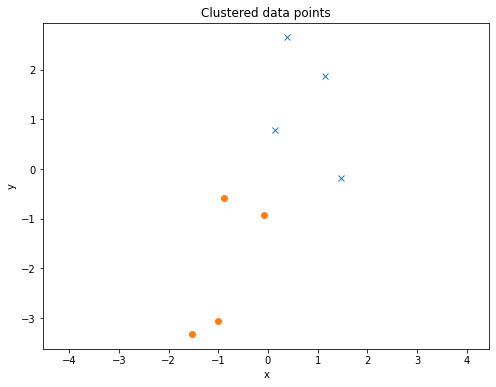

In [95]:
cluster(N, X, expectation)

In [96]:
entanglement = []
partition = [0,4,2,6]
for state in evolved_state:
    entanglement.append(entanglement_entropy(state,partition))

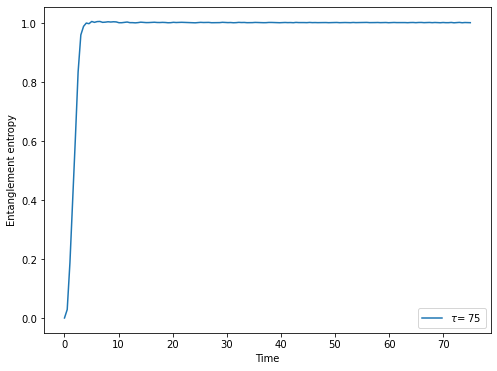

In [97]:
plt.figure(figsize = (8,6))
plt.plot(tlist, entanglement, label = r'$\tau$= 75')
plt.ylabel('Entanglement entropy')
plt.xlabel('Time')
plt.legend(loc = 0)

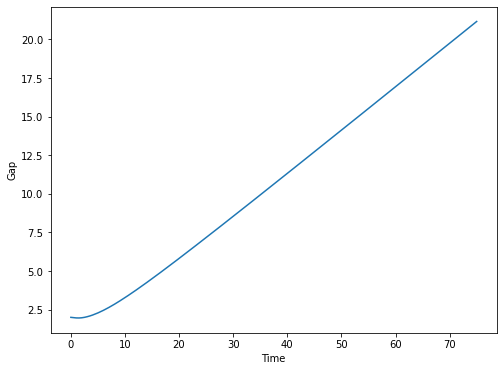

In [98]:
H_t = []
for t in tlist:
    H_t.append(H_time(t, Hb, Hp, tau))
energy0, energy1 = gap_evolution(H_t, tlist, plot = True)

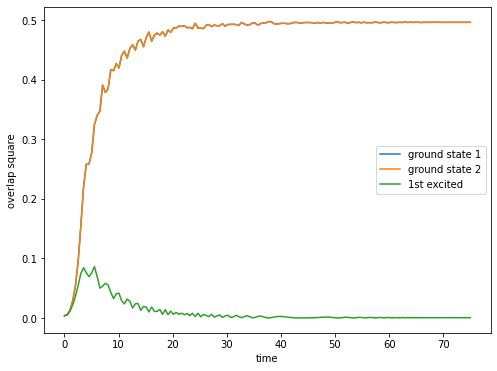

In [99]:
# overlap of the evolved state with the target ground state of Hp
overlap = overlap_with_ground(Hp, evolved_state, tlist)

## Different rates tau

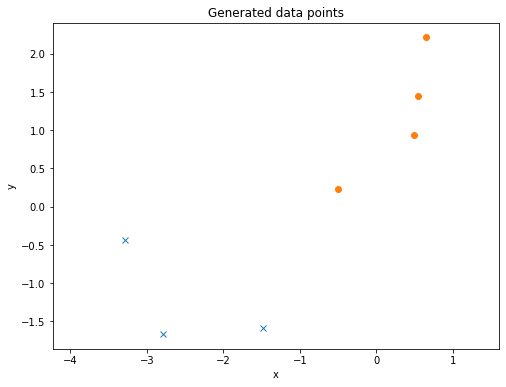

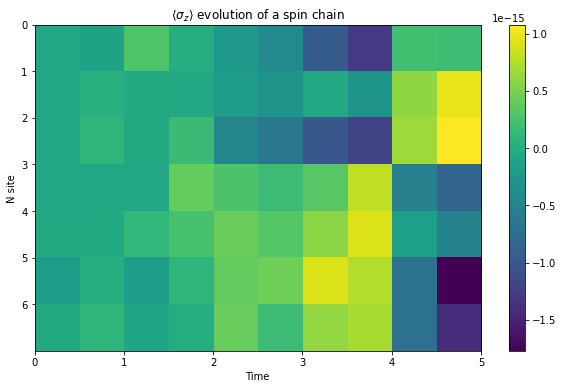

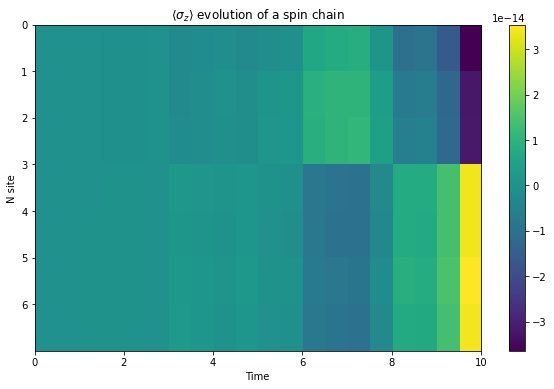

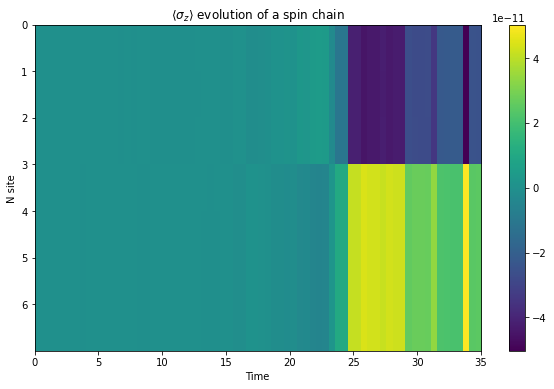

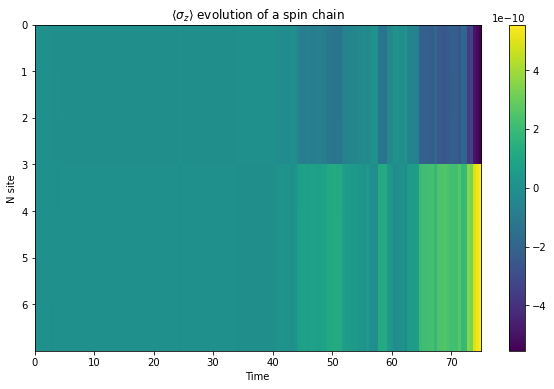

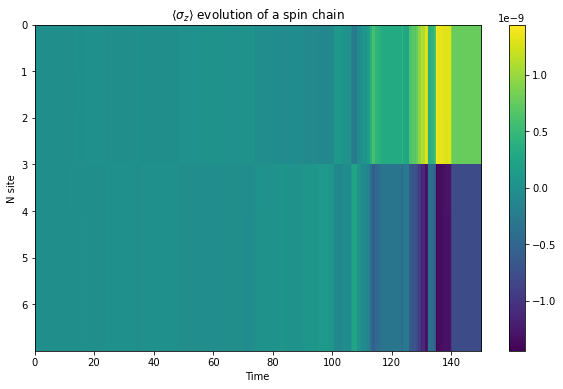

In [100]:
n1 = 4
n2 = 3

N = n1 + n2 # number of data points = length of the spin chin

X = generate_data(n1,n2)

Hb = generate_Hb(N)
Hp = generate_Hp(N,X)

ground = Hb.groundstate(sparse=False, tol=0, maxiter=100000)
psi0 = ground[1] # initial state is the ground state of Hb
time_lists = []
expectations = []
evolved_states = []
# time dependent hamiltonian
H = [[Hb, Hb_coeff], [Hp, Hp_coeff]]

tau_list = [5, 10, 35, 75, 150] # time scale of the adiabatic evolution
for tau in tau_list:
    args = {'tau': tau}
    tlist = np.linspace(0, tau, tau*2)
    time_lists.append(tlist)

    expectation, evolved_state = adiabatic_evolution(H, N, args, psi0, tlist, plot = True)
    expectations.append(expectation)
    evolved_states. append(evolved_state)

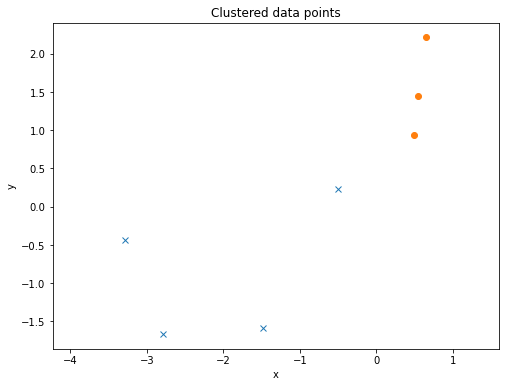

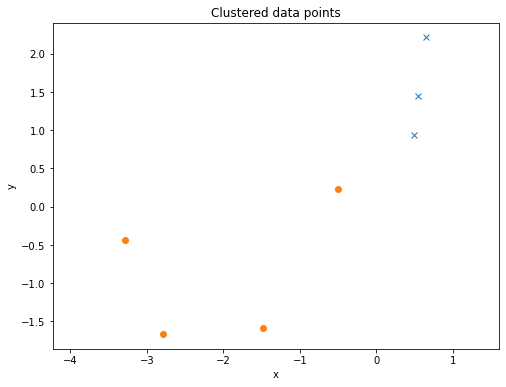

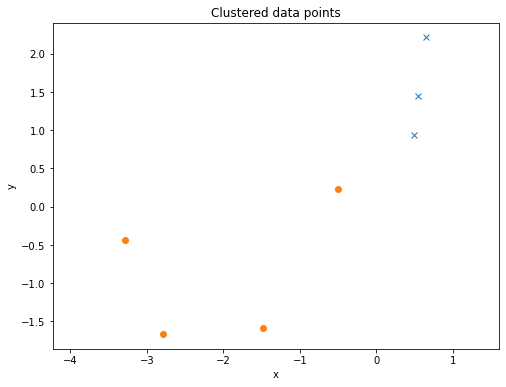

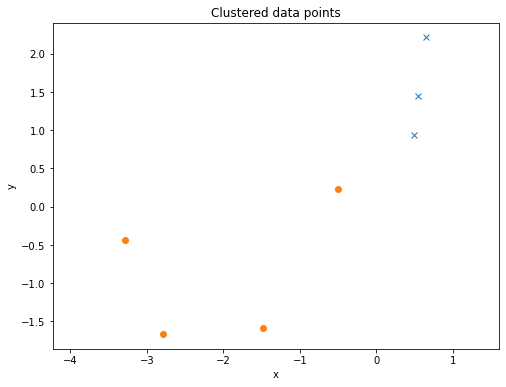

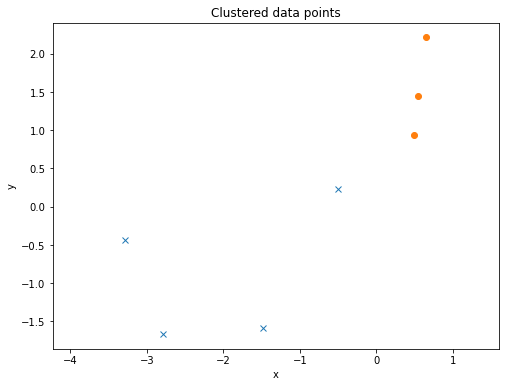

In [101]:
for expectation in expectations:
    cluster(N, X, expectation)

In [102]:
entanglements = []
partition = [0,2, 4]
for evolved_state in evolved_states:
    entanglement = []
    for state in evolved_state:
        entanglement.append(entanglement_entropy(state,partition))
    entanglements.append(entanglement)

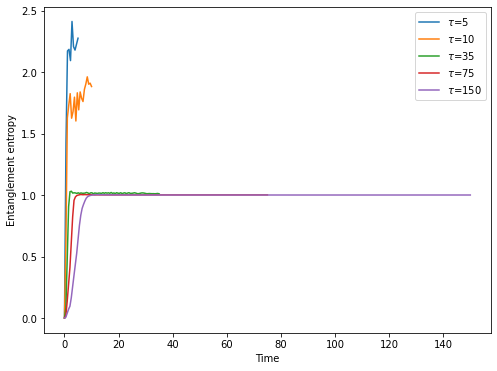

In [103]:
plt.figure(figsize = (8,6))
for i in range(0, len(tau_list)):
    plt.plot(time_lists[i], entanglements[i], label = r'$\tau$=%.0f'%tau_list[i])
plt.ylabel('Entanglement entropy')
plt.xlabel('Time')
plt.legend(loc = 0)

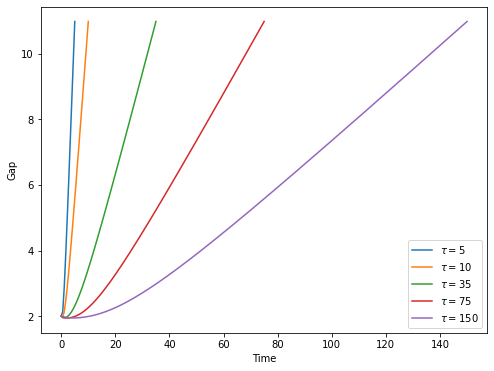

In [104]:
# gap entre els dos ground states (degenerats) i el 1st excited
plt.figure(figsize = (8,6))
for i in range(0, len(tau_list)):
    H_t = []
    for t in time_lists[i]:
        H_t.append(H_time(t, Hb, Hp, tau_list[i]))
    energy0, energy1 = gap_evolution(H_t, time_lists[i], plot = False)
    plt.plot(time_lists[i], np.subtract(energy1,energy0), label = r'$\tau=$%.0f'%tau_list[i])
plt.xlabel('Time')
plt.ylabel('Gap')
plt.legend(loc = 0)

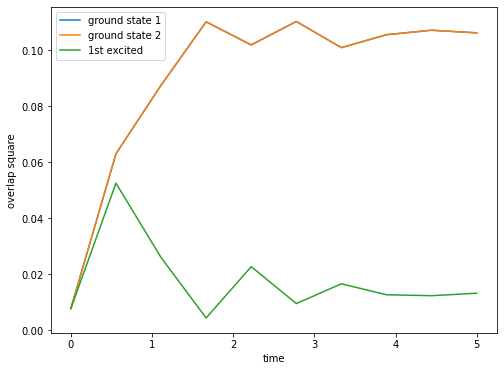

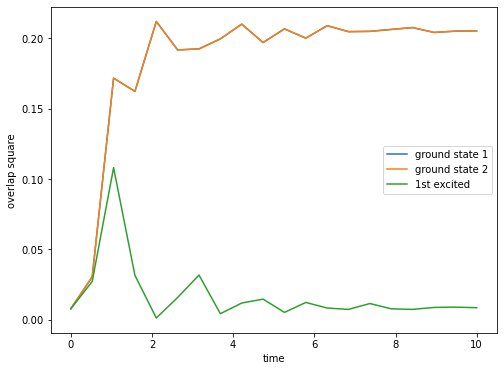

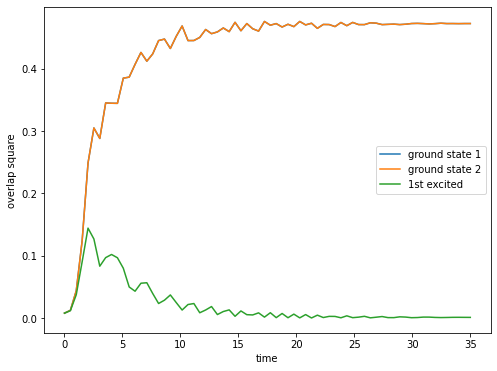

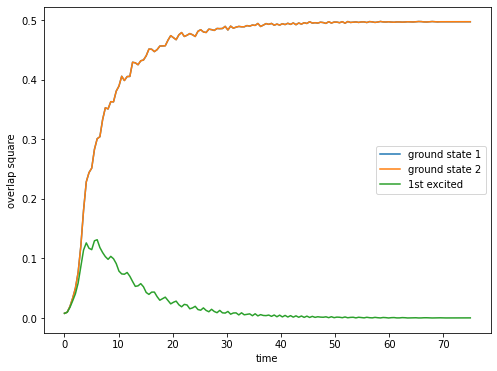

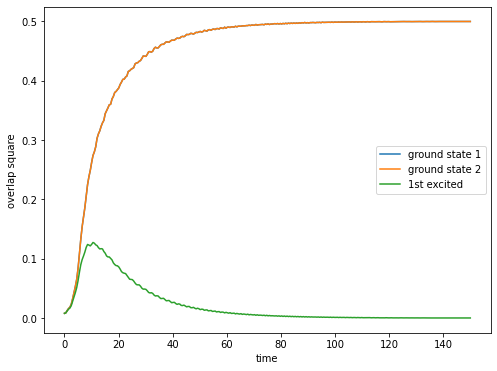

In [105]:
for i in range(0, len(time_lists)):
    evolved_state = evolved_states[i]
    tlist = time_lists[i]
    overlap_with_ground(Hp, evolved_state, tlist)

# Reducing the problem 1 qubit

Let $\displaystyle x_1,...,x_n$ be the data points that we want to separate. Then $\displaystyle X=[x_1,...,x_n]$ is an $\displaystyle m\times n$ matrix and the optimization problem that we have to solve to separate the data points in two clusters is:
$\displaystyle \text{argmin}_{s\in\{-1,1\}^n}-\sum_{i,j=1}^nQ_{ij}s_is_j$ 

where $\displaystyle Q_{ij}=x_i^Tx_j$. 
Obviously the solutions are degenerate because we could rename the clusters. That means that if $\displaystyle s_\gamma = -1$ and $\displaystyle s_{\gamma^c} = 1$ is a solution, then $\displaystyle s_\gamma = 1$ and $\displaystyle s_{\gamma^c} = -1$ is also a solution. To avoid this ambiguity, we can fix the cluster to which one of the points belongs, for instance, we can make $\displaystyle s_n=1$. Then the optimization problem becomes:
$\displaystyle \text{argmin}_{s\in\{-1,1\}^{n-1}}-\sum_{i,j=1}^{n-1}Q_{ij}s_is_j-2\sum_{j=1}^{n-1}Q_{nj}s_j-Q_{nn}$ 

We can simply consider this problem as finding the ground state of the Hamiltonian:

$\displaystyle H_P-\sum_{i,j=1}^{n-1}Q_{ij}\sigma_z^i\sigma_z^j-2\sum_{j=1}^{n-1}Q_{nj}\sigma_z^j$ 

This can be done using Quantum Annealing. We consider the hamiltonian

$\displaystyle H_B=-\sum_{i=1}^n\sigma_x^i$

whose ground state $|\psi(0)\rangle$ is easier to calculate. Then we construct the Hamiltonian:

$H(t)=(1-\frac{t}{\tau})H_B+\frac{t}{\tau}H_P$

and consider the evolution for a time $t\in[0,\tau]$ of the state $|\psi(0)\rangle$ under this hamiltonian.

According to the adiabatic theorem, the state:

$|\psi(t)\rangle=\sum_{i=0}^{2^n-1}a_i(t)|\psi_i\rangle$

will tend to evolve towards the ground state of $H_P$ if the evolution is done sufficiently slow. Then, in principle the maximum of the $|a_i(\tau)|^2$ will indicate which is the basis vector $|\psi_i\rangle$ which is the solution to the optimization problem.

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

def generate_Hp(N, X):
    # N is the length of the chain = total number of points
    # X is the array of data points
    Q = np.transpose(X)@X
    
    si = qeye(2)
    sz = sigmaz()

    sz_list = []

    for n in range(N-1):
        op_list = []
        for m in range(N-1):
            op_list.append(si)

        op_list[n] = sz
        sz_list.append(tensor(op_list))
    op_list = []
    for m in range(N-1):
        op_list.append(si)
    I = tensor(op_list)

    # construct the hamiltonian
    Hp = 0

    for n in range(N-1):
        for m in range(N-1):
            Hp += - Q[n,m] * sz_list[n] * sz_list[m]
    for n in range(N-1):
        Hp += -2 * Q[N-1][n] * sz_list[n] * I
    return Hp

def generate_Hb(N):
    # N is the length of the chain
    
    si = qeye(2)
    sx = sigmax()

    sx_list = []

    for n in range(N-1):
        op_list = []
        for m in range(N-1):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

    # construct the hamiltonian
    Hb = 0

    for n in range(N-1):
        Hb += - sx_list[n]
        
    return Hb

# now we build the time-dependent terms of the Hamiltonian H(t):

def Hp_coeff(t, args):
    tau = args['tau'] # time scale of the adiabatic evolution
    return t/tau

def Hb_coeff(t,args):
    tau = args['tau'] # time scale of the adiabatic evolution
    return 1-t/tau

def adiabatic_evolution(H, N, args, psi0, tlist, plot = True):
    # evolve and calculate expectation values
    # H: Hamiltonian in the format H = [[Hb, Hb_coeff],[Hp, Hp_coeff]]
    # args: arguments of the time dependent function of the hamiltonian, args = {'tau': tau}
    # psi0: initial state to be evolved
    # tlist: list of times for which the evolution is calculated

    c_op_list = [] # we are not using any colapse operators
    si = qeye(2)
    sz = sigmaz()
    sz_list = []

    for n in range(N-1):
        op_list = []
        for m in range(N-1):
            op_list.append(si)
        op_list[n] = sz
        sz_list.append(tensor(op_list))
     
    options = Options(nsteps=100000, store_states = True)
    result = mesolve(H, psi0, tlist, c_op_list, sz_list, args = args, options = options) # calculate the expected value of the sigma_z
    #result_state = mesolve(H, psi0, tlist, c_op_list, args = args, options = options) # calculate evolved state at each time
    
    # plot sigma_z evolution
    if plot == True:
        plt.subplots(figsize=(10,6))
        plt.imshow(np.real(result.expect), interpolation = 'nearest', extent=[tlist[0], tlist[-1], N-1, 0], aspect = 'auto')
        plt.aspect_ratio = 1
        plt.colorbar()
        plt.xlabel(r'Time')
        plt.yticks(list(range(N-1)))
        plt.ylabel(r'N site')
        plt.title(r'$\langle\sigma_z\rangle$ evolution of a spin chain')
        
    return result.expect, result.states

def entanglement_entropy(state, partition):
    # Returns the Von Neumann entropy of the partial trace
    # state - state for which we want to calculate the entanglement entropy
    # partition - integer or array of integers from 0 to N-1 that indicate the subsystem
    # with respect to which we calculate the partial trace
    dm = state*state.dag()
    partial_dm = dm.ptrace(partition)
    return entropy_vn(partial_dm, base = 2)

def H_time(t, Hb, Hp, tau):
    # Time dependent hamiltonian as a function
    return (1-t/tau)* Hb + t/tau * Hp
     
def gap_evolution(H, tlist, plot = True):
    # Hamiltonian evaluated at different times
    energy_0 = [] # ground state energies
    energy_1 = [] # first excited state energies
    gap = [] # diference between ground and first excited energies
    
    for H_i in H:
        energies = H_i.eigenenergies(sparse=False, sort='low', eigvals=2, tol=0, maxiter=100000)
        energy_0.append(energies[0])
        energy_1.append(energies[1])
        gap.append(energies[1]-energies[0])

    if plot == True:
        plt.figure(figsize=(8,6))
        plt.plot(tlist, gap)
        plt.xlabel(r'Time')
        plt.ylabel(r'Gap')
    return energy_0, energy_1

def generate_data(n1, n2, plot = True):
    # n1 number of points of the first cluster
    # n2 number of points of the second cluster
    mean1 = [2, 2]
    mean2 = [-2,-2]
    cov = [[1, 0], [0, 1]] 
    # we sample the points from two 2d gaussian distributions
    x1, y1 = np.random.multivariate_normal(mean1, cov, n1).T
    x2, y2 = np.random.multivariate_normal(mean2, cov, n2).T
    points1 = np.array(list(zip(x1,y1)))
    points2 = np.array(list(zip(x2,y2)))
    data = np.concatenate((points1, points2), axis=0).T
    
    if plot == True:
        plt.figure(figsize=(8,6))
        plt.plot(x2, y2, 'x')
        plt.plot(x1, y1, 'o')
        
        plt.title('Generated data points')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis('equal')
    return data

def cluster(N, data, expectation):
    # N: number of data points = number of spins
    # data: data points
    # expectation: sigma_z expectation of each spin for different t
    data_t = data.T
    # list of index corresponding to each cluster
    cluster1 = []
    cluster1.append(data_t[-1])
    cluster2 = []
    for i in range(N-1):
        expectation_i = expectation[i]
        if expectation_i[-1] >= 0:
            cluster1.append(data_t[i])
        else:
            cluster2.append(data_t[i])
    C1 = np.array(list(zip(*cluster1)))
    x1 = C1[0]
    y1 = C1[1]
    C2 = np.array(list(zip(*cluster2)))
    x2 = C2[0]
    y2 = C2[1]
    
    plt.figure(figsize=(8,6))
    plt.plot(x2, y2, 'x')
    plt.plot(x1, y1, 'o')
    plt.title('Clustered data points')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    
    return cluster1, cluster2

def overlap_with_ground(H, states, tlist):
    #n = 1
    #eigenenergies = H.eigenenergies(sparse=False, sort='low', eigvals=2, tol=0, maxiter=100000)
    #if eigenenergies[0] == eigenenergies[1]:
     #   n = 2
    n = 2
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=n, tol=0, maxiter=100000)
    overlaps = []
    for i in range(n):
        overlap = []
        for state in states:
            overlap.append(abs(eigenstates[1][i].overlap(state))**2)
        overlaps.append(overlap)
    plt.figure(figsize=(8,6))
    plt.plot(tlist, overlaps[0], label = 'ground')
    plt.plot(tlist, overlaps[1], label = '1st excited')
    plt.xlabel('time')
    plt.ylabel('overlap square')
    plt.legend()
    return overlaps

def entanglement_ground(H, tlist, partition):
    entanglement = []
    for i in range(0, len(tlist)):
        H_i = H[i]
        eigenstates = H_i.eigenstates(sparse=False, sort='low', eigvals=1, tol=0, maxiter=100000)
        entanglement.append(entanglement_entropy(eigenstates[1][0], partition))
    return entanglement

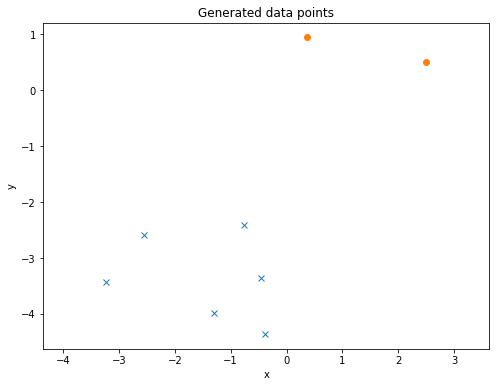

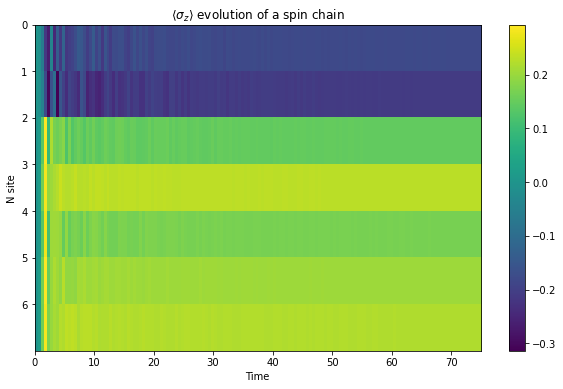

In [50]:
n1 = 2
n2 = 6

N = n1 + n2 # number of data points = length of the spin chin

X = generate_data(n1,n2)

Hb = generate_Hb(N)
Hp = generate_Hp(N,X)

tau = 75 # time scale of the adiabatic evolution
args = {'tau': tau}

ground = Hb.groundstate(sparse=False, tol=0, maxiter=100000)
psi0 = ground[1] # initial state is the ground state of Hb

tlist = np.linspace(0, tau, tau*2)

# time dependent hamiltonian
H = [[Hb, Hb_coeff], [Hp, Hp_coeff]]
expectation, evolved_state = adiabatic_evolution(H, N, args, psi0, tlist, plot = True)

([array([-0.75884199, -2.40624333]),
  array([-0.45065505, -3.35832093]),
  array([-3.22973095, -3.43776843]),
  array([-2.54766894, -2.58933155]),
  array([-0.3794623 , -4.35868232]),
  array([-1.28953055, -3.98895627])],
 [array([2.49924503, 0.50175981]), array([0.36542558, 0.94576993])])

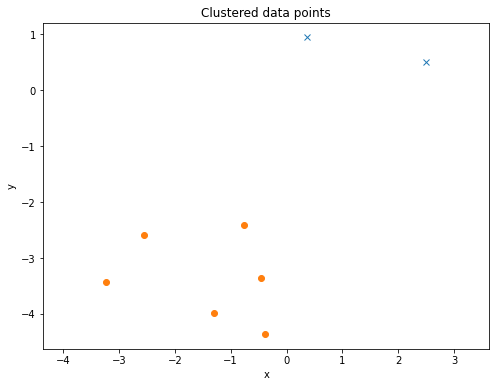

In [51]:
cluster(N, X, expectation)

In [52]:
entanglement = []
partition = [0,2, 4]
for state in evolved_state:
    entanglement.append(entanglement_entropy(state,partition))

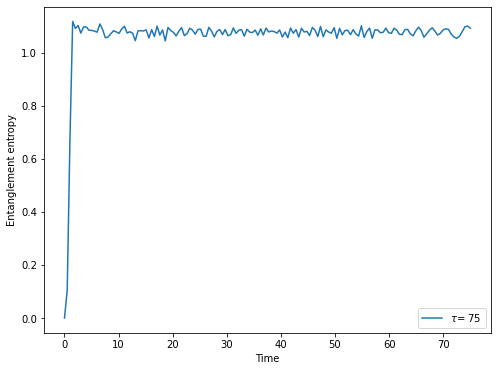

In [53]:
plt.figure(figsize = (8,6))
plt.plot(tlist, entanglement, label = r'$\tau$= 75')
plt.ylabel('Entanglement entropy')
plt.xlabel('Time')
plt.legend(loc = 0)

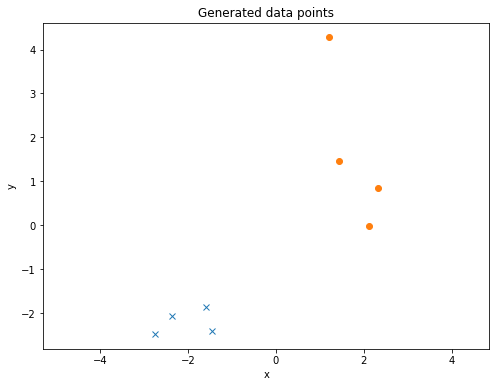

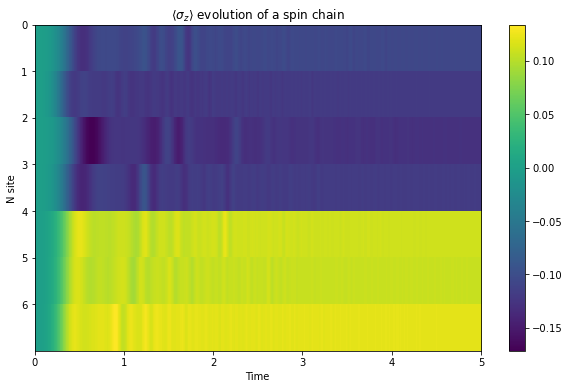

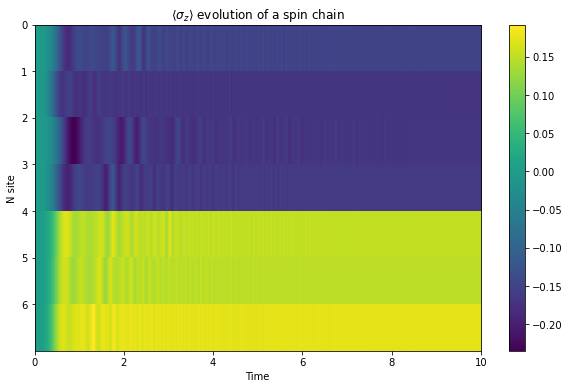

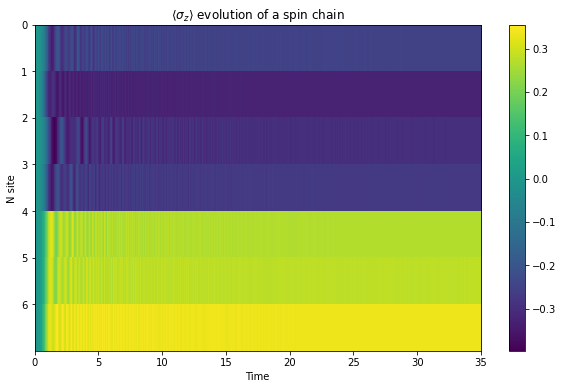

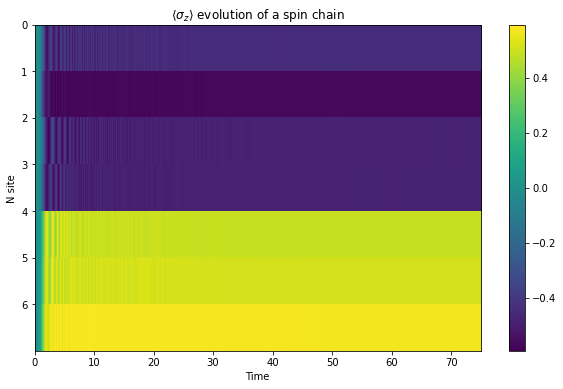

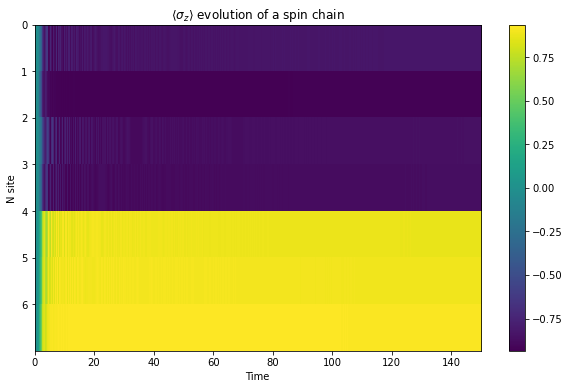

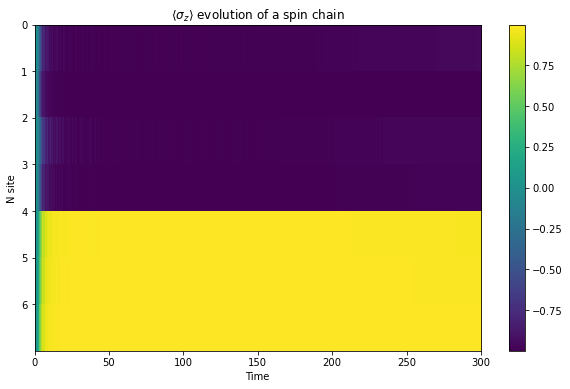

In [70]:
n1 = 4
n2 = 4

N = n1 + n2 # number of data points = length of the spin chin

X = generate_data(n1,n2)

Hb = generate_Hb(N)
Hp = generate_Hp(N,X)

ground = Hb.groundstate(sparse=False, tol=0, maxiter=100000)
psi0 = ground[1] # initial state is the ground state of Hb
time_lists = []
expectations = []
evolved_states = []
# time dependent hamiltonian
H = [[Hb, Hb_coeff], [Hp, Hp_coeff]]

tau_list = [5, 10, 35, 75, 150, 300] # time scale of the adiabatic evolution
for tau in tau_list:
    args = {'tau': tau}
    tlist = np.linspace(0, tau, 600)
    time_lists.append(tlist)

    expectation, evolved_state = adiabatic_evolution(H, N, args, psi0, tlist, plot = True)
    expectations.append(expectation)
    evolved_states. append(evolved_state)

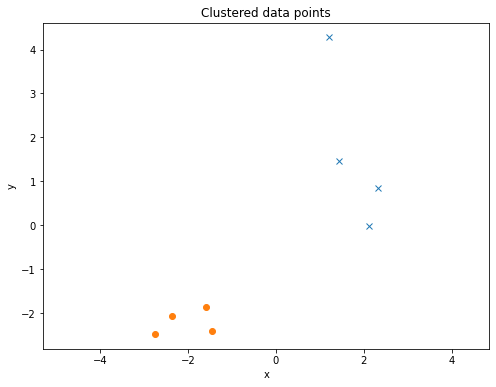

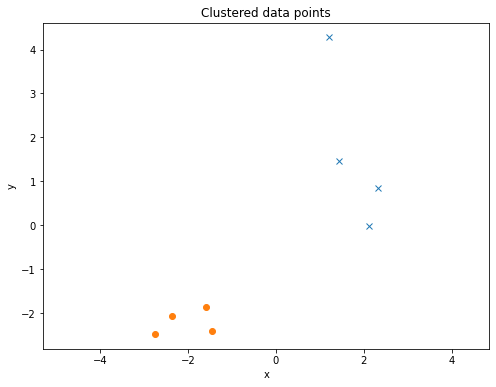

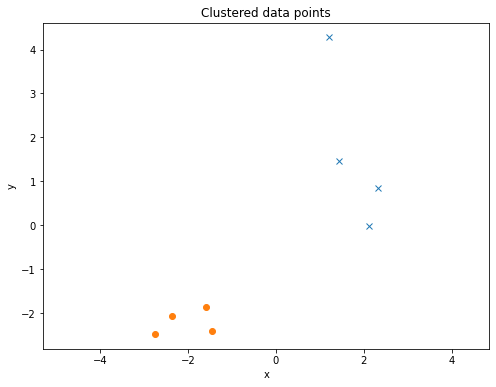

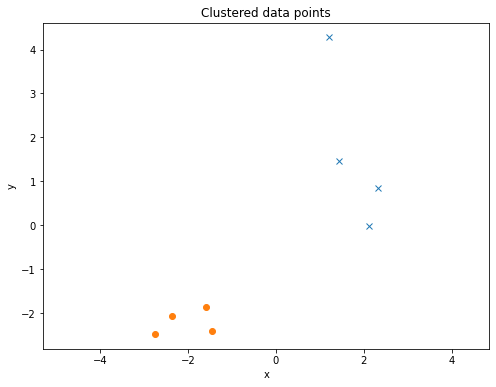

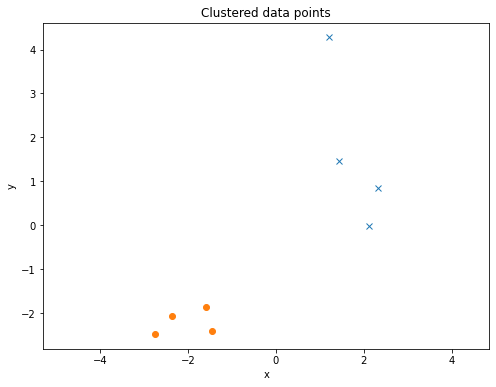

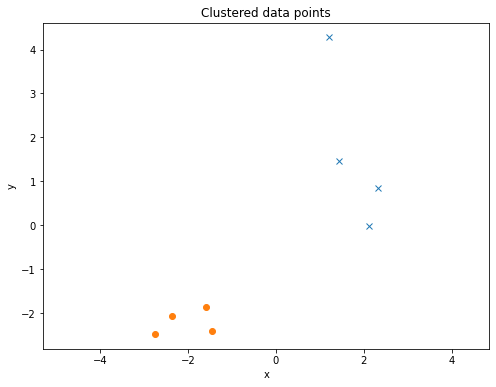

In [71]:
for expectation in expectations:
    cluster(N, X, expectation)

In [72]:
entanglements = []
partition = [0,2, 4]
for evolved_state in evolved_states:
    entanglement = []
    for state in evolved_state:
        entanglement.append(entanglement_entropy(state,partition))
    entanglements.append(entanglement)

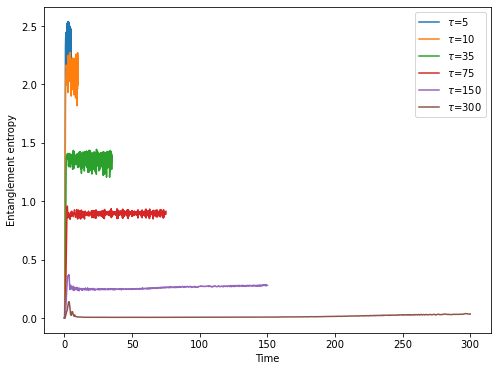

In [73]:
plt.figure(figsize = (8,6))
for i in range(0, len(tau_list)):
    plt.plot(time_lists[i], entanglements[i], label = r'$\tau$=%.0f'%tau_list[i])
plt.ylabel('Entanglement entropy')
plt.xlabel('Time')
plt.legend(loc = 0)

for tau =  5 minimum gap = 1.3942948650643814
for tau =  10 minimum gap = 1.3942948650643814
for tau =  35 minimum gap = 1.3942948650643814
for tau =  75 minimum gap = 1.3942948650643814
for tau =  150 minimum gap = 1.3942948650643814
for tau =  300 minimum gap = 1.3942948650643814


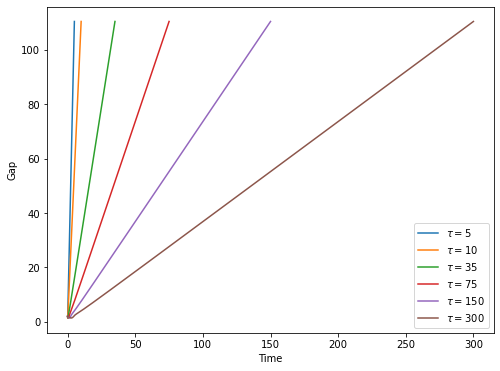

In [74]:
plt.figure(figsize = (8,6))
for i in range(0, len(tau_list)):
    H_t = []
    for t in time_lists[i]:
        H_t.append(H_time(t, Hb, Hp, tau_list[i]))
    energy0, energy1 = gap_evolution(H_t, time_lists[i], plot = False)
    print('for tau = ',tau_list[i],'minimum gap =', np.min(np.subtract(energy1,energy0)))
    plt.plot(time_lists[i], np.subtract(energy1,energy0), label = r'$\tau=$%.0f'%tau_list[i])
plt.xlabel('Time')
plt.ylabel('Gap')
plt.legend(loc = 0)


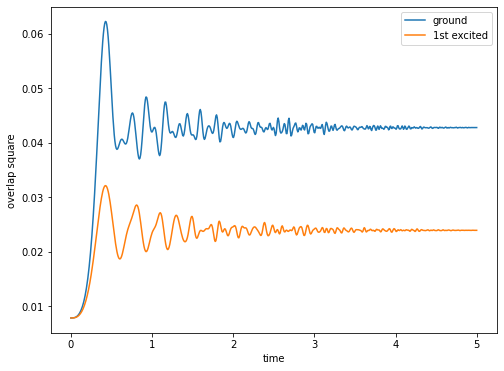

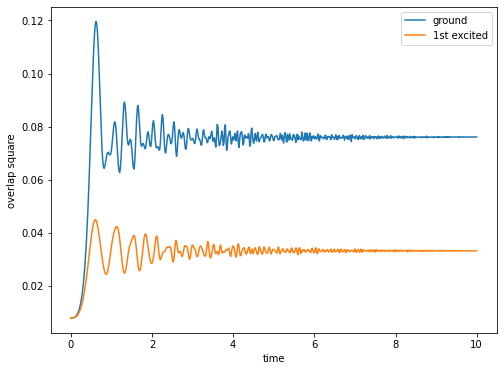

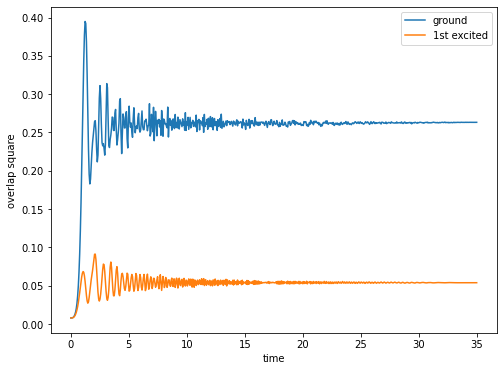

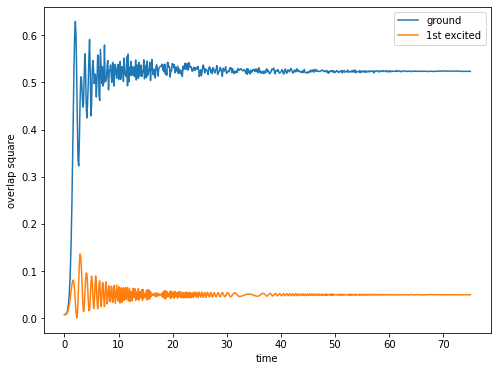

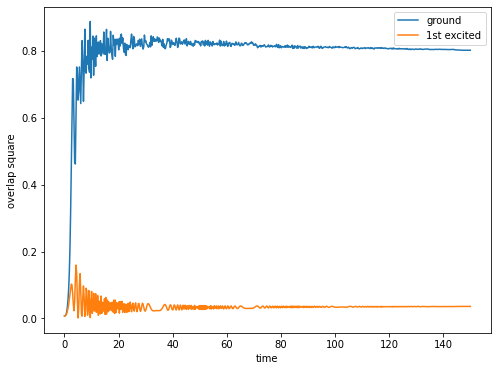

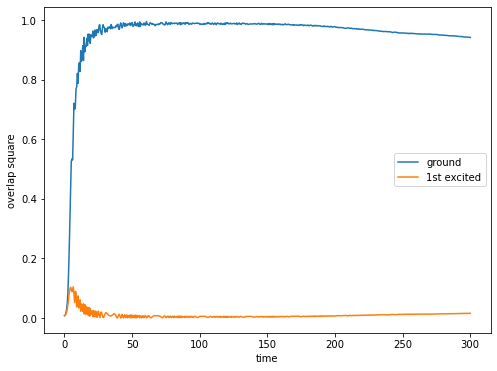

In [75]:
# overlap of the evolved state with the ground and the 1st excited state
for i in range(0, len(time_lists)):
    evolved_state = evolved_states[i]
    tlist = time_lists[i]
    overlap_with_ground(Hp, evolved_state, tlist)

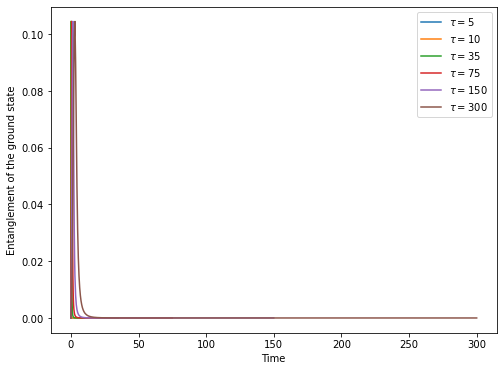

In [76]:
plt.figure(figsize = (8,6))
for i in range(0, len(tau_list)):
    H_t = []
    for t in time_lists[i]:
        H_t.append(H_time(t, Hb, Hp, tau_list[i]))
    entanglement = entanglement_ground(H_t, time_lists[i], [0,1])
    plt.plot(time_lists[i], entanglement, label = r'$\tau=$%.0f'%tau_list[i])
plt.xlabel('Time')
plt.ylabel('Entanglement of the ground state')
plt.legend(loc = 0)
